In [17]:
import pandas as pd
import geopandas as gpd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib notebook

In [18]:
ownership = gpd.read_file(r'J:\Geology\WSGS\GIS\land ownership\BLM__Surface_Management_Agency.shp') #reads in the hydraulic basin units and adds an area column
ownership = ownership.to_crs({'init': 'epsg:3732'})

<IPython.core.display.Javascript object>


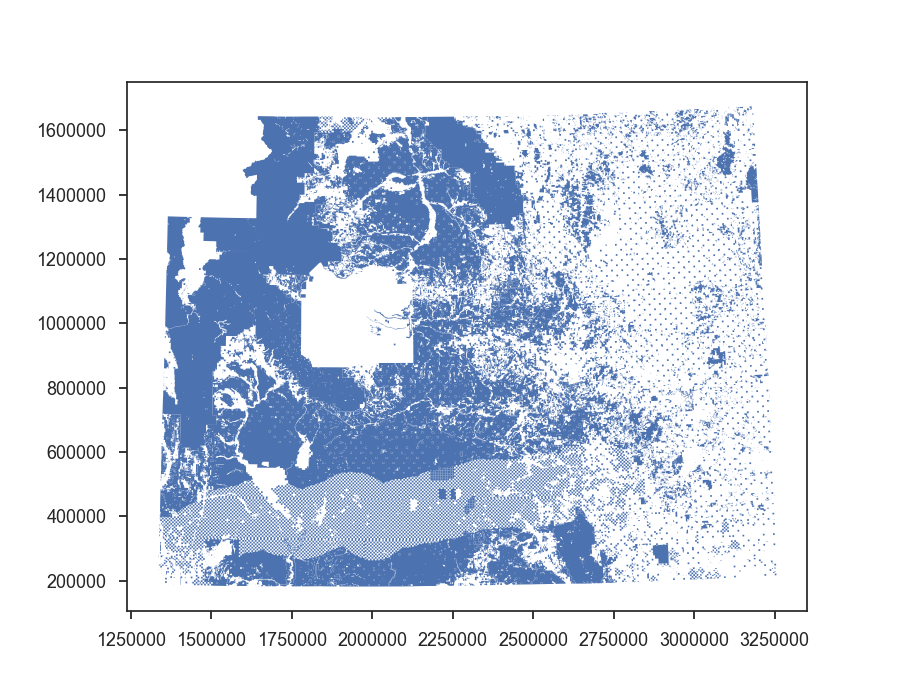

In [19]:
ownership[(ownership['SURFACE'] == 'State') | (ownership['SURFACE'] == 'State (University of Wyoming)')
         |(ownership['SURFACE'] == 'State (Wyoming Game & Fish)') |(ownership['SURFACE'] == 'State (State Parks & Hist Sites)')
          |(ownership['SURFACE'] == 'Bureau of Land Management') |(ownership['SURFACE'] == 'Forest Service')].plot()

ModuleNotFoundError: No module named 'georasters'